In [1]:
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import matplotlib.scale as scale
%matplotlib inline
from statsmodels.tsa.stattools import coint
import statsmodels.formula.api as smf
import scipy.stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

In [2]:
# Get Price Data
bnc = pd.read_csv('bnc_indexprice.csv', index_col=False)

In [3]:
bnc.timestamp = pd.to_datetime(bnc.timestamp, dayfirst = True)
bnc.index = bnc.timestamp
bnc['price'] =(bnc.high + bnc.low)/2

In [4]:
# Get Block by Block Data
df = pd.read_csv('data/Blockchair/blockchair.csv')
df.time = pd.to_datetime(df.time, dayfirst=True)
df.index = df.time

C:\Users\laide\Miniconda3\envs\venture_256\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.



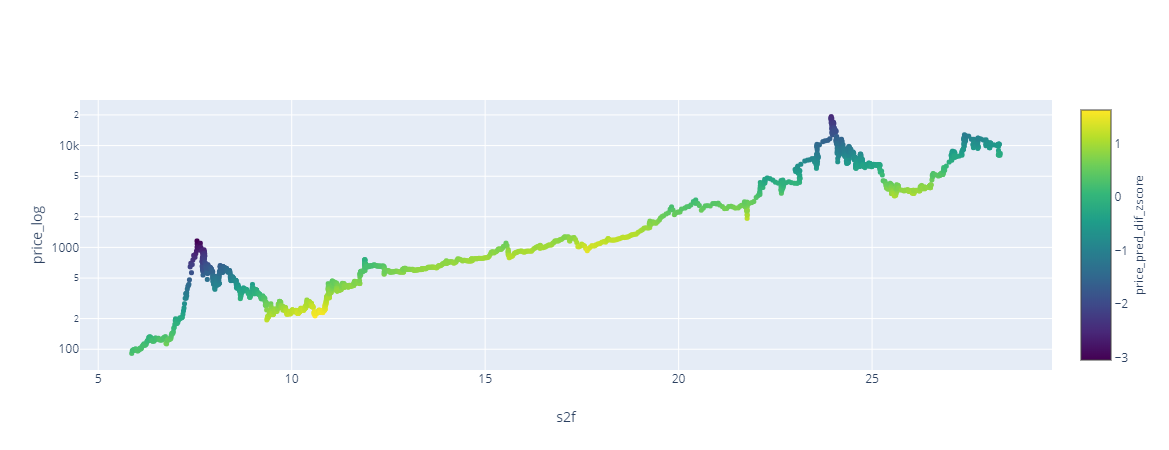

In [5]:
# Compute S2F Model Values

def s2f_model(df, tf): 
    """ 
    Inputs: 
    df (dataframe): 'blockchair.csv' dataframe declaration as well as a timeframe. 
    tf (timeframe): accepts the following strings: 'D', 'W', 'M' and 'Y' depending on the necessary granularity. 
    
    Outputs: 
    Returns a new dataframe with new columns computing S2F, S2F Multiples, Z-Scores and OLS Regression
    """
    
    df1 = df.resample(tf)['generation'].sum().to_frame() # get number of blocks produced in a certain time frame 
    df1['stock'] = df1.generation.cumsum() # get running total of stock 

    if tf == 'W':
        df1['year_flow'] = df1.generation.rolling(52).sum()
    elif tf == 'M':
        df1['year_flow'] = df1.generation.rolling(12).sum()
    elif tf == 'D':
        df1['year_flow'] = df1.generation.rolling(365).sum()
    if tf == 'Y':
        df1['year_flow'] = df1.generation.rolling(1).sum()

    def difference(df, s): # Take a column as input
        return [((df[s][i] - df[s][i-1])/df[s][i-1]) for i in range(len(df))]

    df1['s2f'] = df1.stock / df1.year_flow
    df1['s2f_log'] = np.log(df1.s2f)
    df1['s2f_dif'] = difference(df1, 's2f')
    prices = bnc.resample(tf)['price'].mean().to_frame()
    df2 = pd.merge(prices, df1, left_index= True, right_index= True, how='inner')

    df2['price_log'] = np.log(df2.price)
    df2['price_dif'] = difference(df2, 'price')
    df2['s2f_price_dif']= df2.s2f_dif/df2.price_dif
    df2['s2f_multiple'] = df2.s2f_log / df2.price_log
    df2['s2f_zscore'] = scipy.stats.zscore(df2.s2f_multiple)

    # OLS Regression
    df2['X'] = df2.s2f_log.values.reshape(-1,1)
    df2['Y'] = df2.price_log.values.reshape(-1,1)

    est = smf.ols(formula='Y ~ X', data=df2).fit()
    df2['price_pred'] = est.predict() 
    df2['price_pred_dif'] = df2.price_pred - df2.Y
    df2['price_pred_dif_zscore'] = scipy.stats.zscore(df2.price_pred_dif)

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(go.Scatter(x = df2['s2f'],
                             y = df2['price_log'],
                             mode='markers',
                             showlegend=False,
                             marker=dict(size=5,
                                         color=df2['price_pred_dif_zscore'], #set color equal to a variable
                                         colorscale='viridis', # one of plotly colorscales
                                         colorbar=dict(title='price_pred_dif_zscore', titleside="right"),
                                         showscale=True)
                            ),
                  secondary_y=True)

    fig.add_trace(go.Scatter(x = df2['s2f'],
                             y = df2['price'],
                             showlegend=False,
                             mode='markers',
                             marker=dict(size=5,
                                         color=df2['price_pred_dif_zscore'], #set color equal to a variable
                                         colorscale=[[0.0, "rgba(0,0,0,0)"], [1.0, "rgba(0,0,0,0)"]], # one of plotly colorscales
                                         colorbar=dict(title='price_pred_dif_zscore', titleside="right"),
                                         showscale=False)
                            ),
                  secondary_y=False)

    fig.update_layout(xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="s2f",font=dict(size=14))),
                      yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="price_log",font=dict(size=14))))
    fig.update_yaxes(type='log',secondary_y=False)
    fig.update_yaxes(tickvals=[],secondary_y=True)
    fig.show()
    
    return df2

day = s2f_model(df, 'D')

In [185]:
def s2f_generation_halved_time_series_model(df, tf): 
    """ 
    Inputs: 
    df (dataframe): 'blockchair.csv' dataframe declaration as well as a timeframe. 
    tf (timeframe): accepts the following strings: 'D', 'W', 'M' and 'Y' depending on the necessary granularity. 
    
    Outputs: 
    Returns a new dataframe with new columns computing S2F, S2F Multiples, Z-Scores and OLS Regression
    """
    
    # Extend the timestamp index of the dataframe up to next generation
    temp_df = pd.DataFrame({'time': pd.Series(['2026-01-31'])}, columns=df.columns)
    temp_df.time = pd.to_datetime(temp_df['time'], dayfirst=True)
    temp_df.index = temp_df.time
    df = df.append(temp_df)
    df = df.append(df.iloc[-2:].asfreq('D'))
    
    df1 = df.resample(tf)['generation'].sum().to_frame() # get number of blocks produced in a certain time frame 
    
    # Fill in generation estimates
    df1['generation'].loc['2019-10-08':'2020-5-18'] = df1['generation'].loc['2017-10-08':'2019-10-08'].mean()
    df1['generation'].loc['2020-5-18':'2024-5-18'] =  df1['generation'].loc['2017-10-08':'2019-10-08'].mean()/2
    df1['generation'].loc['2024-5-18':] = df1['generation'].loc['2017-10-08':'2019-10-08'].mean()/4
    
    df1['stock'] = df1.generation.cumsum() # get running total of stock

    if tf == 'W':
        df1['year_flow'] = df1.generation.rolling(52).sum()
    elif tf == 'M':
        df1['year_flow'] = df1.generation.rolling(12).sum()
    elif tf == 'D':
        df1['year_flow'] = df1.generation.rolling(365).sum()
    if tf == 'Y':
        df1['year_flow'] = df1.generation.rolling(1).sum()

    def difference(df, s): # Take a column as input
        return [((df[s][i] - df[s][i-1])/df[s][i-1]) for i in range(len(df))]

    df1['s2f'] = df1.stock / df1.year_flow
    df1['s2f_log'] = np.log(df1.s2f)
    df1['s2f_dif'] = difference(df1, 's2f')
    prices = bnc.resample(tf)['price'].mean().to_frame()
    prices = prices.append(temp_df)
    prices = prices.append(prices.iloc[-3:].asfreq('D'))
    df2 = pd.merge(prices, df1, left_index= True, right_index= True, how='inner')

    df2['price_log'] = np.log(df2.price)
    df2['price_dif'] = difference(df2, 'price')
    df2['s2f_price_dif']= df2.s2f_dif/df2.price_dif
    df2['s2f_multiple'] = df2.s2f_log / df2.price_log
    df2['s2f_zscore'] = scipy.stats.zscore(df2.s2f_multiple)

    # OLS Regression
    df2['X'] = df2.s2f_log.values.reshape(-1,1)
    df2['Y'] = df2.price_log.values.reshape(-1,1)

    est = smf.ols(formula='Y ~ X', data=df2.loc[:'2019-10-01']).fit()
    df2['price_pred'] = est.predict(df2['X'])
    df2['price_pred_dif'] = np.nan
    df2['price_pred_dif_zscore'] = np.nan
    df2['price_pred_dif'].loc[:'2019-10-01'] = df2.price_pred.loc[:'2019-10-01'] - df2.Y.loc[:'2019-10-01']
    df2['price_pred_dif_zscore'].loc[:'2019-10-01'] = scipy.stats.zscore(df2.price_pred_dif.loc[:'2019-10-01'])

    # Create column 'Days until next halving' of the generation
    df2['days_until_next_halving'] = np.nan
    
    # Future dates are just estimates
    halving_dates = [datetime(2016,7,9), datetime(2020,5,18)]#, datetime(2012,11,28),'2020-5-18', '2024-5-18']
    prev_date = df2.index[0]
    for i in range(len(halving_dates)):
        date = halving_dates[i]
        if date > df2.index[-1]:
            df2['days_until_next_halving'].loc[prev_date:df2.index[-1]] = date - df2.loc[prev_date:df2.index[-1]].index
        else:
            df2['days_until_next_halving'].loc[prev_date:date] = date - df2.loc[prev_date:date].index
        prev_date = date
        
    df2['days_until_next_halving'] = pd.to_timedelta(df2['days_until_next_halving']).dt.days
    
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(go.Scatter(x = df2.index,
                             y = df2['price_log'],
                             mode='lines+markers',
                             showlegend=True,
                             marker=dict(size=2,
                                         color=df2['price_pred_dif_zscore'], #set color equal to a variable
                                         colorscale='viridis', # one of plotly colorscales
                                         colorbar=dict(title='price_pred_dif_zscore', titleside="right"),
                                         showscale=True)
                            ),
                  secondary_y=True)
    
    fig.add_trace(go.Scatter(x = df2.index,
                             y = df2['price_log'],
                             mode='lines+markers',
                             showlegend=True,
                             marker=dict(size=2,
                                         color=df2['days_until_next_halving'], #set color equal to a variable
                                         colorscale='Rainbow', # one of plotly colorscales
                                         colorbar=dict(x=1.15, title='days_until_next_halving', titleside="right"),
                                         showscale=True)
                            ),
                  secondary_y=True)
    
    fig.add_trace(go.Scatter(x = df2.index,
                             y = df2['price_pred'],
                             mode='lines',
                             showlegend=True,
                            ),
                  secondary_y=True)

    fig.add_trace(go.Scatter(x = df2.index,
                             y = df2['price'],
                             showlegend=False,
                             mode='lines',
                             line=dict(width=0) #set color equal to a variable
                            ),
                  secondary_y=False)

    fig.update_layout(xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Time",font=dict(size=14))),
                      yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="price_log",font=dict(size=14))),
                      legend=dict(x= -0.1, y=-0.2))
    fig.update_yaxes(type='log',secondary_y=False)
    fig.update_yaxes(tickvals=[],secondary_y=True)
    fig.show()
    
    return df2

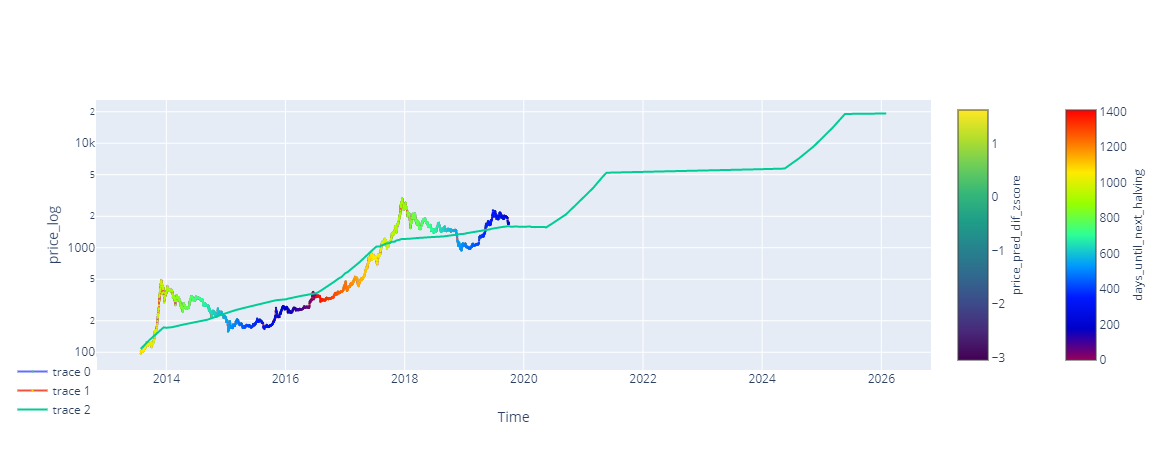

In [186]:
day2 = s2f_generation_halved_time_series_model(df, 'D')